# **Identifying Key Entities in Recipe Data**


**Business Objective**:
The goal of this assignment is to train a Named Entity Recognition (NER) model using Conditional Random Fields (CRF) to extract key entities from recipe data. The model will classify words into predefined categories such as ingredients, quantities and units, enabling the creation of a structured database of recipes and ingredients that can be used to power advanced features in recipe management systems, dietary tracking apps, or e-commerce platforms.

### **Data Description**
The given data is in JSON format, representing a **structured recipe ingredient list** with **Named Entity Recognition (NER) labels**. Below is a breakdown of the data fields:

```json
[
    {
        "input": "6 Karela Bitter Gourd Pavakkai Salt 1 Onion 3 tablespoon Gram flour besan 2 teaspoons Turmeric powder Haldi Red Chilli Cumin seeds Jeera Coriander Powder Dhania Amchur Dry Mango Sunflower Oil",
        "pos": "quantity ingredient ingredient ingredient ingredient ingredient quantity ingredient quantity unit ingredient ingredient ingredient quantity unit ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient"
    },
    {
      "input": "2-1/2 cups rice cooked 3 tomatoes teaspoons BC Belle Bhat powder 1 teaspoon chickpea lentils 1/2 cumin seeds white urad dal mustard green chilli dry red 2 cashew or peanuts 1-1/2 tablespoon oil asafoetida",
      "pos": "quantity unit ingredient ingredient quantity ingredient unit ingredient ingredient ingredient ingredient quantity unit ingredient ingredient quantity ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient quantity ingredient ingredient ingredient quantity unit ingredient ingredient"
    }
]


| **Key**  | **Description**  |
|----------|-----------------|
| `input`  | Contains a raw ingredient list from a recipe. |
| `pos`    | Represents the corresponding part-of-speech (POS) tags or NER labels, identifying quantities, ingredients, and units. |


## **1** Import libraries

#### **1.1** Installation of sklearn-crfsuite

sklearn-crfsuite is a Python wrapper for CRFsuite, a fast and efficient implementation of Conditional Random Fields (CRFs). It is designed to integrate seamlessly with scikit-learn for structured prediction tasks such as Named Entity Recognition (NER), Part-of-Speech (POS) tagging, and chunking.

In [1]:
# installation of sklearn_crfsuite
!pip install sklearn_crfsuite==0.5.0

#### **1.2** Import necessary libraries

In [2]:
# Import warnings
import warnings
warnings.filterwarnings('ignore')

In [4]:
# Import necessary libraries
import json  # For handling JSON data
import pandas as pd  # For data manipulation and analysis
import re  # For regular expressions (useful for text preprocessing)
import matplotlib.pyplot as plt  # For visualisation
import seaborn as sns  # For advanced data visualisation
import sklearn_crfsuite  # CRF (Conditional Random Fields) implementation for sequence modeling
import numpy as np  # For numerical computations
# Saving and loading machine learning models
import joblib
import random
import spacy
from IPython.display import display, Markdown # For displaying well-formatted output

from fractions import Fraction  # For handling fractional values in numerical data
# Importing tools for feature engineering and model training
from collections import Counter  # For counting occurrences of elements in a list
from sklearn.model_selection import train_test_split  # For splitting dataset into train and test sets
from sklearn_crfsuite import metrics  # For evaluating CRF models
from sklearn_crfsuite.metrics import flat_classification_report
from sklearn.utils.class_weight import compute_class_weight
from collections import Counter
from sklearn.metrics import confusion_matrix

In [6]:
# Ensure pandas displays full content
pd.set_option('display.max_colwidth', None)
pd.set_option('display.expand_frame_repr', False)

## **2** Data Ingestion and Preparation <font color = red>[25 marks]</font> <br>

#### **2.1** *Read Recipe Data from Dataframe and prepare the data for analysis* <font color = red>[12 marks]</font> <br>
Read the data from JSON file, print first five rows and describe the dataframe

##### **2.1.1** **Define a *load_json_dataframe* function** <font color = red>[7 marks]</font> <br>

Define a function that takes path of the ingredient_and_quantity.json file and reads it, convert it into dataframe - df and return it.

In [26]:
# define a function to load json file to a dataframe
def load_json_dataframe(file_path):
    """
    Load a JSON file and convert it to a pandas DataFrame.
    
    Args:
        file_path (str): Path to the JSON file.
        
    Returns:
        pd.DataFrame: DataFrame containing the JSON data.
    """
    with open(file_path, 'r') as file:
        data = json.load(file)
    return pd.DataFrame(data) if isinstance(data, list) else pd.DataFrame([data])

##### **2.1.2** **Execute the *load_json_dataframe* function** <font color = red>[2 marks]</font> <br>

In [27]:
# read the json file by giving the file path and create a dataframe

recipe = load_json_dataframe("ingredient_and_quantity.json")

##### **2.1.3** **Describe the dataframe** <font color = red>[3 marks]</font> <br>

Print first five rows of dataframe along with dimensions. Display the information of dataframe

In [28]:
print(recipe.info())
recipe.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 285 entries, 0 to 284
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   input   285 non-null    object
 1   pos     285 non-null    object
dtypes: object(2)
memory usage: 4.6+ KB
None


,input,pos
0,6 Karela Bitter Gourd Pavakkai Salt 1 Onion 3 tablespoon Gram flour besan 2 teaspoons Turmeric powder Haldi Red Chilli Cumin seeds Jeera Coriander Powder Dhania Amchur Dry Mango Sunflower Oil,quantity ingredient ingredient ingredient ingredient ingredient quantity ingredient quantity unit ingredient ingredient ingredient quantity unit ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient
1,2-1/2 cups rice cooked 3 tomatoes teaspoons BC Belle Bhat powder 1 teaspoon chickpea lentils 1/2 cumin seeds white urad dal mustard green chilli dry red 2 cashew or peanuts 1-1/2 tablespoon oil asafoetida,quantity unit ingredient ingredient quantity ingredient unit ingredient ingredient ingredient ingredient quantity unit ingredient ingredient quantity ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient quantity ingredient ingredient ingredient quantity unit ingredient ingredient
2,1-1/2 cups Rice Vermicelli Noodles Thin 1 Onion sliced 1/2 cup Carrots Gajjar chopped 1/3 Green peas Matar 2 Chillies 1/4 teaspoon Asafoetida hing Mustard seeds White Urad Dal Split Ghee sprig Curry leaves Salt Lemon juice,quantity unit ingredient ingredient ingredient ingredient quantity ingredient ingredient quantity unit ingredient ingredient ingredient quantity ingredient ingredient ingredient quantity ingredient quantity unit ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient unit ingredient ingredient ingredient ingredient ingredient
3,500 grams Chicken 2 Onion chopped 1 Tomato 4 Green Chillies slit inch Ginger finely 6 cloves Garlic 1/2 teaspoon Turmeric powder Haldi Garam masala tablespoon Sesame Gingelly Oil 1/4 Methi Seeds Fenugreek Coriander Dhania Dry Red Fennel seeds Saunf cups Sorrel Leaves Gongura picked and,quantity unit ingredient quantity ingredient ingredient quantity ingredient quantity ingredient ingredient ingredient unit ingredient ingredient quantity unit ingredient quantity unit ingredient ingredient ingredient ingredient ingredient unit ingredient ingredient ingredient quantity ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient unit ingredient ingredient ingredient ingredient ingredient
4,1 tablespoon chana dal white urad 2 red chillies coriander seeds 3 inches ginger onion tomato Teaspoon mustard asafoetida sprig curry,quantity unit ingredient ingredient ingredient ingredient quantity ingredient ingredient ingredient ingredient quantity unit ingredient ingredient ingredient unit ingredient ingredient unit ingredient


In [29]:
# print the dimensions of dataframe - df
print(recipe.shape)

(285, 2)


In [30]:
# print the information of the dataframe
print(recipe.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 285 entries, 0 to 284
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   input   285 non-null    object
 1   pos     285 non-null    object
dtypes: object(2)
memory usage: 4.6+ KB
None


#### **2.2** *Recipe Data Manipulation* <font color = red>[13 marks]</font> <br>
Create derived metrics in dataframe and provide insights of the dataframe

##### **2.2.1** **Create input_tokens and pos_tokens columns by splitting the input and pos from the dataframe** <font color = red>[3 marks]</font> <br>
Split the input and pos into input_tokens and pos_tokens in the dataframe and display it in the dataframe

In [31]:
# split the input and pos into input_tokens and pos_tokens in the dataframe

# Tokenize input
recipe['input_tokens'] = recipe['input'].str.split()

# Tokenize POS
recipe['pos_tokens'] = recipe['pos'].str.split()

In [13]:
recipe.head()

,input,pos,input_tokens,pos_tokens
0,6 Karela Bitter Gourd Pavakkai Salt 1 Onion 3 tablespoon Gram flour besan 2 teaspoons Turmeric powder Haldi Red Chilli Cumin seeds Jeera Coriander Powder Dhania Amchur Dry Mango Sunflower Oil,quantity ingredient ingredient ingredient ingredient ingredient quantity ingredient quantity unit ingredient ingredient ingredient quantity unit ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient,"[6, Karela, Bitter, Gourd, Pavakkai, Salt, 1, Onion, 3, tablespoon, Gram, flour, besan, 2, teaspoons, Turmeric, powder, Haldi, Red, Chilli, Cumin, seeds, Jeera, Coriander, Powder, Dhania, Amchur, Dry, Mango, Sunflower, Oil]","[quantity, ingredient, ingredient, ingredient, ingredient, ingredient, quantity, ingredient, quantity, unit, ingredient, ingredient, ingredient, quantity, unit, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient]"
1,2-1/2 cups rice cooked 3 tomatoes teaspoons BC Belle Bhat powder 1 teaspoon chickpea lentils 1/2 cumin seeds white urad dal mustard green chilli dry red 2 cashew or peanuts 1-1/2 tablespoon oil asafoetida,quantity unit ingredient ingredient quantity ingredient unit ingredient ingredient ingredient ingredient quantity unit ingredient ingredient quantity ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient quantity ingredient ingredient ingredient quantity unit ingredient ingredient,"[2-1/2, cups, rice, cooked, 3, tomatoes, teaspoons, BC, Belle, Bhat, powder, 1, teaspoon, chickpea, lentils, 1/2, cumin, seeds, white, urad, dal, mustard, green, chilli, dry, red, 2, cashew, or, peanuts, 1-1/2, tablespoon, oil, asafoetida]","[quantity, unit, ingredient, ingredient, quantity, ingredient, unit, ingredient, ingredient, ingredient, ingredient, quantity, unit, ingredient, ingredient, quantity, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, quantity, ingredient, ingredient, ingredient, quantity, unit, ingredient, ingredient]"
2,1-1/2 cups Rice Vermicelli Noodles Thin 1 Onion sliced 1/2 cup Carrots Gajjar chopped 1/3 Green peas Matar 2 Chillies 1/4 teaspoon Asafoetida hing Mustard seeds White Urad Dal Split Ghee sprig Curry leaves Salt Lemon juice,quantity unit ingredient ingredient ingredient ingredient quantity ingredient ingredient quantity unit ingredient ingredient ingredient quantity ingredient ingredient ingredient quantity ingredient quantity unit ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient unit ingredient ingredient ingredient ingredient ingredient,"[1-1/2, cups, Rice, Vermicelli, Noodles, Thin, 1, Onion, sliced, 1/2, cup, Carrots, Gajjar, chopped, 1/3, Green, peas, Matar, 2, Chillies, 1/4, teaspoon, Asafoetida, hing, Mustard, seeds, White, Urad, Dal, Split, Ghee, sprig, Curry, leaves, Salt, Lemon, juice]","[quantity, unit, ingredient, ingredient, ingredient, ingredient, quantity, ingredient, ingredient, quantity, unit, ingredient, ingredient, ingredient, quantity, ingredient, ingredient, ingredient, quantity, ingredient, quantity, unit, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, unit, ingredient, ingredient, ingredient, ingredient, ingredient]"
3,500 grams Chicken 2 Onion chopped 1 Tomato 4 Green Chillies slit inch Ginger finely 6 cloves Garlic 1/2 teaspoon Turmeric powder Haldi Garam masala tablespoon Sesame Gingelly Oil 1/4 Methi Seeds Fenugreek Coriander Dhania Dry Red Fennel seeds Saunf cups Sorrel Leaves Gongura picked and,quantity unit ingredient quantity ingredient ingredient quantity ingredient quantity ingredient ingredient ingredient unit ingredient ingredient qua

In [15]:
# display first five rows of the dataframe - df
display(recipe.head())

,input,pos,input_tokens,pos_tokens
0,6 Karela Bitter Gourd Pavakkai Salt 1 Onion 3 tablespoon Gram flour besan 2 teaspoons Turmeric powder Haldi Red Chilli Cumin seeds Jeera Coriander Powder Dhania Amchur Dry Mango Sunflower Oil,quantity ingredient ingredient ingredient ingredient ingredient quantity ingredient quantity unit ingredient ingredient ingredient quantity unit ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient,"[6, Karela, Bitter, Gourd, Pavakkai, Salt, 1, Onion, 3, tablespoon, Gram, flour, besan, 2, teaspoons, Turmeric, powder, Haldi, Red, Chilli, Cumin, seeds, Jeera, Coriander, Powder, Dhania, Amchur, Dry, Mango, Sunflower, Oil]","[quantity, ingredient, ingredient, ingredient, ingredient, ingredient, quantity, ingredient, quantity, unit, ingredient, ingredient, ingredient, quantity, unit, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient]"
1,2-1/2 cups rice cooked 3 tomatoes teaspoons BC Belle Bhat powder 1 teaspoon chickpea lentils 1/2 cumin seeds white urad dal mustard green chilli dry red 2 cashew or peanuts 1-1/2 tablespoon oil asafoetida,quantity unit ingredient ingredient quantity ingredient unit ingredient ingredient ingredient ingredient quantity unit ingredient ingredient quantity ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient quantity ingredient ingredient ingredient quantity unit ingredient ingredient,"[2-1/2, cups, rice, cooked, 3, tomatoes, teaspoons, BC, Belle, Bhat, powder, 1, teaspoon, chickpea, lentils, 1/2, cumin, seeds, white, urad, dal, mustard, green, chilli, dry, red, 2, cashew, or, peanuts, 1-1/2, tablespoon, oil, asafoetida]","[quantity, unit, ingredient, ingredient, quantity, ingredient, unit, ingredient, ingredient, ingredient, ingredient, quantity, unit, ingredient, ingredient, quantity, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, quantity, ingredient, ingredient, ingredient, quantity, unit, ingredient, ingredient]"
2,1-1/2 cups Rice Vermicelli Noodles Thin 1 Onion sliced 1/2 cup Carrots Gajjar chopped 1/3 Green peas Matar 2 Chillies 1/4 teaspoon Asafoetida hing Mustard seeds White Urad Dal Split Ghee sprig Curry leaves Salt Lemon juice,quantity unit ingredient ingredient ingredient ingredient quantity ingredient ingredient quantity unit ingredient ingredient ingredient quantity ingredient ingredient ingredient quantity ingredient quantity unit ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient unit ingredient ingredient ingredient ingredient ingredient,"[1-1/2, cups, Rice, Vermicelli, Noodles, Thin, 1, Onion, sliced, 1/2, cup, Carrots, Gajjar, chopped, 1/3, Green, peas, Matar, 2, Chillies, 1/4, teaspoon, Asafoetida, hing, Mustard, seeds, White, Urad, Dal, Split, Ghee, sprig, Curry, leaves, Salt, Lemon, juice]","[quantity, unit, ingredient, ingredient, ingredient, ingredient, quantity, ingredient, ingredient, quantity, unit, ingredient, ingredient, ingredient, quantity, ingredient, ingredient, ingredient, quantity, ingredient, quantity, unit, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, unit, ingredient, ingredient, ingredient, ingredient, ingredient]"
3,500 grams Chicken 2 Onion chopped 1 Tomato 4 Green Chillies slit inch Ginger finely 6 cloves Garlic 1/2 teaspoon Turmeric powder Haldi Garam masala tablespoon Sesame Gingelly Oil 1/4 Methi Seeds Fenugreek Coriander Dhania Dry Red Fennel seeds Saunf cups Sorrel Leaves Gongura picked and,quantity unit ingredient quantity ingredient ingredient quantity ingredient quantity ingredient ingredient ingredient unit ingredient ingredient qua

##### **2.2.2** **Provide the length for input_tokens and pos_tokens and validate their length** <font color = red>[2 marks]</font> <br>

Create input_length and pos_length columns in the dataframe and validate both the lengths. Check for the rows that are unequal in input and pos length


In [32]:
# create input_length and pos_length columns for the input_tokens and pos-tokens
recipe['input_length'] = recipe['input_tokens'].apply(len)
recipe['pos_length'] = recipe['pos_tokens'].apply(len)

In [33]:
# check for the equality of input_length and pos_length in the dataframe
unequal_lengths = recipe[recipe['input_length'] != recipe['pos_length']]

if not unequal_lengths.empty:
    print("Unequal lengths found:")
    display(unequal_lengths[['input_length', 'pos_length']])
    print("Indexes of rows with unequal lengths:", unequal_lengths.index.tolist())
    print("Number of rows with unequal lengths:", len(unequal_lengths))
else:
    print("All rows have equal input_length and pos_length.")

Unequal lengths found:


,input_length,pos_length
17,15,14
27,37,36
79,38,37
164,54,53
207,18,17


Indexes of rows with unequal lengths: [17, 27, 79, 164, 207]
Number of rows with unequal lengths: 5


##### **2.2.3** **Define a unique_labels function and validate the labels in pos_tokens** <font color = red>[2 marks]</font> <br>

Define a unique_labels function which checks for all the unique pos labels in the recipe & execute it.


In [34]:
# Define a unique_labels function to checks for all the unique pos labels in the recipe & print it
def unique_labels(recipe_df):
    """
    Print all unique POS labels in the 'pos' column of the DataFrame.
    
    Args:
        df (pd.DataFrame): DataFrame containing a 'pos' column.
    """
    pos_labels_unique = set()
    for pos_list in recipe_df['pos_tokens']:
        pos_labels_unique.update(pos_list)

    print("Unique POS labels:", pos_labels_unique)
    return pos_labels_unique

# Call the unique_labels function to print all the unique pos labels in the recipe
unique_labels(recipe)
    

Unique POS labels: {'ingredient', 'quantity', 'unit'}


{'ingredient', 'quantity', 'unit'}

##### **2.2.3** **Provide the insights seen in the recipe data after validation** <font color = red>[1 marks]</font> <br>

Provide the indexes that requires cleaning and formatting in the dataframe

Based on the analysis of the unequal rows where `input_length` does not match `pos_length`, the following indexes require cleaning and formatting:

**Problematic Rows Identified:**
- **Index 17**: input_length=15, pos_length=14 (missing 1 POS label)
- **Index 27**: input_length=37, pos_length=36 (missing 1 POS label)  
- **Index 79**: input_length=38, pos_length=37 (missing 1 POS label)
- **Index 164**: input_length=54, pos_length=53 (missing 1 POS label)
- **Index 207**: input_length=18, pos_length=17 (missing 1 POS label)

**Key Issues:**
1. All problematic rows have **fewer POS labels than input tokens**
2. This creates **misalignment** between tokens and their corresponding labels
3. Such misalignment will cause **training errors** in the CRF model
4. The data integrity is compromised for proper sequence labeling

**Required Action:**
These 5 rows (indexes: 17, 27, 79, 164, 207) need to be **dropped** from the dataset to ensure:
- Perfect alignment between input tokens and POS labels
- Clean training data for the CRF model
- Reliable sequence labeling performance


##### **2.2.4** **Drop the rows that have invalid data provided in previous cell** <font color = red> [2 marks]</font> <br>

In [35]:
# drop the irrelevant recipe data
recipe = recipe.drop(unequal_lengths.index)
print("Data after dropping rows with unequal lengths:", len(recipe))

# Reset the index of the DataFrame after dropping rows
recipe = recipe.reset_index(drop=True)

Data after dropping rows with unequal lengths: 280


##### **2.2.5** **Update the input_length & pos_length in dataframe**<font color = red> [2 marks]</font> <br>

In [36]:
# update the input and pos length in input_length and pos_length
recipe['input_length'] = recipe['input_tokens'].apply(len)
recipe['pos_length'] = recipe['pos_tokens'].apply(len)

##### **2.2.6** **Validate the input_length and pos_length by checking unequal rows** <font color = red> [1 marks]</font> <br>

In [38]:
# validate the input length and pos length as input_length and pos_length
unequal_lengths_after_drop = recipe[recipe['input_length'] != recipe['pos_length']]
print("Number of rows with unequal lengths after drop:", len(unequal_lengths_after_drop))

if len(unequal_lengths_after_drop) > 0:
    print("All rows have equal input_length and pos_length after dropping irrelevant data.")
    display(unequal_lengths_after_drop[['input_length', 'pos_length']])
    print("Indexes of rows with unequal lengths:", unequal_lengths_after_drop.index.tolist())
else:
    print("All rows have equal input_length and pos_length after dropping irrelevant data.")

Number of rows with unequal lengths after drop: 0
All rows have equal input_length and pos_length after dropping irrelevant data.


## **3** Train Validation Split (70 train - 30 val) <font color = red>[6 marks]</font> <br>

#### **3.1** *Perform train and validation split ratio* <font color = red>[6 marks]</font> <br>
Split the dataset with the help of input_tokens and pos_tokens and make a ratio of 70:30 split for training and validation datasets.

###### **3.1.1** **Split the dataset into train_df and val_df into 70:30 ratio** <font color = red> [1 marks]</font> <br>

In [40]:
# split the dataset into training and validation sets
train_df, valid_df = train_test_split(recipe, test_size=0.3, random_state=42)
train_df.reset_index(drop=True)
valid_df.reset_index(drop=True)

print("Training set size:", len(train_df))
print("Validation set size:", len(valid_df))
print("Training size ratio:", len(train_df) / (len(train_df) + len(valid_df)))
print("Validation size ratio:", len(valid_df) / (len(train_df) + len(valid_df)))

Training set size: 196
Validation set size: 84
Training size ratio: 0.7
Validation size ratio: 0.3


###### **3.1.2** **Print the first five rows of train_df and val_df** <font color = red> [1 marks]</font> <br>

In [41]:
# print the first five rows of train_df
display(train_df.head())

,input,pos,input_tokens,pos_tokens,input_length,pos_length
175,250 grams Okra Oil 1 Onion finely chopped Tomato Grated teaspoon Ginger 2 Garlic Finely 1/2 Cumin seeds 1/4 Teaspoon asafoetida cup cottage cheese pinched coriander powder mango red chilli turmeric,quantity unit ingredient ingredient quantity ingredient ingredient ingredient ingredient ingredient unit ingredient quantity ingredient ingredient quantity ingredient ingredient quantity unit ingredient unit ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient,"[250, grams, Okra, Oil, 1, Onion, finely, chopped, Tomato, Grated, teaspoon, Ginger, 2, Garlic, Finely, 1/2, Cumin, seeds, 1/4, Teaspoon, asafoetida, cup, cottage, cheese, pinched, coriander, powder, mango, red, chilli, turmeric]","[quantity, unit, ingredient, ingredient, quantity, ingredient, ingredient, ingredient, ingredient, ingredient, unit, ingredient, quantity, ingredient, ingredient, quantity, ingredient, ingredient, quantity, unit, ingredient, unit, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient]",31,31
55,200 grams Paneer Homemade Cottage Cheese 2 Potato Aloo Bay leaf tej patta Dry Red Chilli 1 tablespoon Panch Phoran Masala roasted and powdered Tomato big sized teaspoon Turmeric powder Haldi Cumin seeds Jeera Ginger grated Salt 1/2 Sugar Sunflower Oil,quantity unit ingredient ingredient ingredient ingredient quantity ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient quantity unit ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient unit ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient quantity ingredient ingredient ingredient,"[200, grams, Paneer, Homemade, Cottage, Cheese, 2, Potato, Aloo, Bay, leaf, tej, patta, Dry, Red, Chilli, 1, tablespoon, Panch, Phoran, Masala, roasted, and, powdered, Tomato, big, sized, teaspoon, Turmeric, powder, Haldi, Cumin, seeds, Jeera, Ginger, grated, Salt, 1/2, Sugar, Sunflower, Oil]","[quantity, unit, ingredient, ingredient, ingredient, ingredient, quantity, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, quantity, unit, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, unit, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, quantity, ingredient, ingredient, ingredient]",41,41
109,500 grams Cabbage Patta Gobi Muttaikose 1 teaspoon Mustard seeds 1-1/2 White Urad Dal Split sprig Curry leaves Green Chilli 1/4 cup Fresh coconut Salt,quantity unit ingredient ingredient ingredient ingredient quantity unit ingredient ingredient quantity ingredient ingredient ingredient ingredient unit ingredient ingredient ingredient ingredient quantity unit ingredient ingredient ingredient,"[500, grams, Cabbage, Patta, Gobi, Muttaikose, 1, teaspoon, Mustard, seeds, 1-1/2, White, Urad, Dal, Split, sprig, Curry, leaves, Green, Chilli, 1/4, cup, Fresh, coconut, Salt]","[quantity, unit, ingredient, ingredient, ingredient, ingredient, quantity, unit, ingredient, ingredient, quantity, ingredient, ingredient, ingredient, ingredient, unit, ingredient, ingredient, ingredient, ingredient, quantity, unit, ingredient, ingredient, ingredient]",25,25
213,500 grams Fresh Figs 1/4 cup Lemon juice 1 teaspoon zest 2 Red Chilli flakes 1/2 Honey Brown Sugar (Demerara Sugar),quantity unit ingredient ingredient quantity unit ingredient ingredient quantity unit ingredient quantity ingredient ingredient ingredient quantity ingredient ingredient ingredient ingredient ingredient,"[500, grams, Fresh, Figs, 1/4, cup, Lemon, juice, 1, teaspoon, zest, 2, Red, Chilli, flakes, 1/2, Honey, Brown, Sugar, (Demerara, Sugar)]","[quantity, unit, ingredient, ingredient, quantity, unit, ingredient, ingredient, qua

In [42]:
# print the first five rows of the val_df
display(valid_df.head())

,input,pos,input_tokens,pos_tokens,input_length,pos_length
33,1 cup Ada 2 liter Milk 3/4 Sugar tablespoon Ghee 1/2 teaspoon Cardamom Powder Elaichi,quantity unit ingredient quantity unit ingredient quantity ingredient unit ingredient quantity unit ingredient ingredient ingredient,"[1, cup, Ada, 2, liter, Milk, 3/4, Sugar, tablespoon, Ghee, 1/2, teaspoon, Cardamom, Powder, Elaichi]","[quantity, unit, ingredient, quantity, unit, ingredient, quantity, ingredient, unit, ingredient, quantity, unit, ingredient, ingredient, ingredient]",15,15
108,1 Carrot Gajjar chopped 7 Potatoes Aloo 2 cups Cauliflower gobi cut to small florets Onion tablespoon Ginger Garlic Paste Salt teaspoons Sunflower Oil 1/2 cup Fresh coconut grated teaspoon Whole Black Peppercorns Green Chillies Fennel seeds Saunf Poppy 6 Cashew nuts inch Cinnamon Stick Dalchini Star anise 3 Cloves Laung Cardamom Elaichi Pods/Seeds Cumin Jeera,quantity ingredient ingredient ingredient quantity ingredient ingredient quantity unit ingredient ingredient ingredient ingredient ingredient ingredient ingredient unit ingredient ingredient ingredient ingredient unit ingredient ingredient quantity unit ingredient ingredient ingredient unit ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient quantity ingredient ingredient unit ingredient ingredient ingredient ingredient ingredient quantity ingredient ingredient ingredient ingredient ingredient ingredient ingredient,"[1, Carrot, Gajjar, chopped, 7, Potatoes, Aloo, 2, cups, Cauliflower, gobi, cut, to, small, florets, Onion, tablespoon, Ginger, Garlic, Paste, Salt, teaspoons, Sunflower, Oil, 1/2, cup, Fresh, coconut, grated, teaspoon, Whole, Black, Peppercorns, Green, Chillies, Fennel, seeds, Saunf, Poppy, 6, Cashew, nuts, inch, Cinnamon, Stick, Dalchini, Star, anise, 3, Cloves, Laung, Cardamom, Elaichi, Pods/Seeds, Cumin, Jeera]","[quantity, ingredient, ingredient, ingredient, quantity, ingredient, ingredient, quantity, unit, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, unit, ingredient, ingredient, ingredient, ingredient, unit, ingredient, ingredient, quantity, unit, ingredient, ingredient, ingredient, unit, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, quantity, ingredient, ingredient, unit, ingredient, ingredient, ingredient, ingredient, ingredient, quantity, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient]",56,56
240,1 tablespoon Sunflower Oil 3 Potato Aloo Ginger paste Green Chilli chopped 1-1/12 tablespoons Sesame seeds Til teaspoon Red powder Cumin Jeera Coriander Powder Dhania 1/2 Garam masala 2 Sweet Chutney Date Tamarind Leaves few,quantity unit ingredient ingredient quantity ingredient ingredient ingredient ingredient ingredient ingredient ingredient quantity unit ingredient ingredient ingredient unit ingredient ingredient ingredient ingredient ingredient ingredient ingredient quantity ingredient ingredient quantity ingredient ingredient ingredient ingredient ingredient ingredient,"[1, tablespoon, Sunflower, Oil, 3, Potato, Aloo, Ginger, paste, Green, Chilli, chopped, 1-1/12, tablespoons, Sesame, seeds, Til, teaspoon, Red, powder, Cumin, Jeera, Coriander, Powder, Dhania, 1/2, Garam, masala, 2, Sweet, Chutney, Date, Tamarind, Leaves, few]","[quantity, unit, ingredient, ingredient, quantity, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, quantity, unit, ingredient, ingredient, ingredient, unit, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, quantity, ingredient, ingredient, quantity, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient]",35,35
259,1 cup green peas gram flour 1/2 cheese tsp ginger 2 chillies turmeric powder cumin teaspoon salt oil,quantity unit ingredient ingredient ingredient ingredient quantity ingredient unit ingredient quantity ingredient i

###### **3.1.3** **Extract the dataset into train_df and val_df into X_train, X_val, y_train and y_val and display their length** <font color = red> [2 marks]</font> <br>

Extract X_train, X_val, y_train and y_val by extracting the list of input_tokens and pos_tokens from train_df and val_df and also display their length

In [44]:
# extract the training and validation sets by taking input_tokens and pos_tokens
X_train = train_df['input_tokens'].tolist()
X_valid = valid_df['input_tokens'].tolist()

y_train = train_df['pos_tokens'].tolist()
y_valid = valid_df['pos_tokens'].tolist()

print("X train:", len(X_train))
print("X valid:", len(X_valid))
print("y train:", len(y_train))
print("y valid:", len(y_valid))

X train: 196
X valid: 84
y train: 196
y valid: 84


In [49]:
# validate the shape of training and validation samples
print("Shape of train_df:", train_df.shape, "and Shape of valid_df:", valid_df.shape)

Shape of train_df: (196, 6) and Shape of valid_df: (84, 6)


###### **3.1.4** **Display the number of unique labels present in y_train** <font color = red> [2 marks]</font> <br>

In [56]:
# Display the number of unique labels present in y_train
display(Markdown(f"##### Number of unique labels in y_train: {len(set([label for sublist in y_train for label in sublist]))}"))
# print the unique labels in y_train
unique_labels = set([label for sublist in y_train for label in sublist])
print("Unique labels in y_train:", unique_labels)

##### Number of unique labels in y_train: 3

Unique labels in y_train: {'ingredient', 'quantity', 'unit'}


## **4** Exploratory Recipe Data Analysis on Training Dataset <font color = red>[16 marks]</font> <br>

#### **4.1** *Flatten the lists for input_tokens & pos_tokens* <font color = red>[2 marks]</font> <br>

Define a function **flatten_list** for flattening the structure for input_tokens and pos_tokens. The input parameter passed to this function is a nested list.

Initialise the dataset_name with a value ***'Training'***




In [ ]:
# flatten the list for nested_list (input_tokens, pos_tokens)
def flatten_list(nested_list):
    """
    Flatten a nested list into a single list.
    
    Args:
        nested_list (list): A list of lists to be flattened.
        
    Returns:
        list: A flattened list containing all elements from the nested lists.
    """
    return [item for sublist in nested_list for item in sublist]

In [58]:
# initialise the dataset_name
dataset_name = 'Training'

#### **4.2** *Extract and validate the tokens after using the flattening technique* <font color = red>[2 marks]</font> <br>

Define a function named ***extract_and_validate_tokens*** with parameters dataframe and dataset_name (Training/Validation), validate the length of input_tokens and pos_tokens from dataframe and display first 10 records for both the input_tokens and pos_tokens. Execute this function




In [61]:
# define a extract_and_validate_tokens with parameters (df, dataset_name)
# call the flatten_list and apply it on input_tokens and pos_tokens
# validate their length and display first 10 records having input and pos tokens

def extract_and_validate_tokens(df, dataset_name):
    """
    Extract and validate tokens from the DataFrame.
    
    Args:
        df (pd.DataFrame): DataFrame containing 'input_tokens' and 'pos_tokens'.
        dataset_name (str): Name of the dataset for display purposes.
        
    Returns:
    tuple: Flattened input tokens and POS tokens.
    """
    input_tokens_flattened = flatten_list(df['input_tokens'].tolist())
    pos_tokens_flattened = flatten_list(df['pos_tokens'].tolist())
    
    if len(input_tokens_flattened) != len(pos_tokens_flattened):
        print(f"Error: Mismatch in lengths of input and pos tokens in {dataset_name} dataset.")
    else:
        print(f"Input tokens and POS tokens have equal lengths in {dataset_name} dataset.")
    
    # Display first 10 records
    print(f"First 10 records of {dataset_name} dataset:")
    for i in range(10):
        print(f"Input: {input_tokens_flattened[i]}, POS: {pos_tokens_flattened[i]}")
    return input_tokens_flattened, pos_tokens_flattened



In [62]:
# extract the tokens and its pos tags
input_tokens_train, pos_tokens_train = extract_and_validate_tokens(train_df, 'Training')
print("\n")
input_tokens_valid, pos_tokens_valid = extract_and_validate_tokens(valid_df, 'Validation')


Input tokens and POS tokens have equal lengths in Training dataset.
First 10 records of Training dataset:
Input: 250, POS: quantity
Input: grams, POS: unit
Input: Okra, POS: ingredient
Input: Oil, POS: ingredient
Input: 1, POS: quantity
Input: Onion, POS: ingredient
Input: finely, POS: ingredient
Input: chopped, POS: ingredient
Input: Tomato, POS: ingredient
Input: Grated, POS: ingredient


Input tokens and POS tokens have equal lengths in Validation dataset.
First 10 records of Validation dataset:
Input: 1, POS: quantity
Input: cup, POS: unit
Input: Ada, POS: ingredient
Input: 2, POS: quantity
Input: liter, POS: unit
Input: Milk, POS: ingredient
Input: 3/4, POS: quantity
Input: Sugar, POS: ingredient
Input: tablespoon, POS: unit
Input: Ghee, POS: ingredient


#### **4.3** *Categorise tokens into labels (unit, ingredient, quantity)* <font color = red>[2 marks]</font> <br>

Define a function ***categorize_tokens*** to categorise tokens into ingredients, units and quantities by using extracted tokens in the previous code and return a list of ingredients, units and quantities. Execute this function to get the list.



In [65]:
# define a categorize_tokens function and provide the tokens and pos_tags as parameters and create ingredient, unit and quantity list and return it
# validate the list that it comprised of these labels, if not return empty arrays

def categorize_tokens(tokens, pos_tags):
    """
    Categorize tokens into ingredients, units, and quantities based on their POS tags.
    
    Args:
        tokens (list): List of input tokens.
        pos_tags (list): List of POS tags corresponding to the tokens.
        
    Returns:
        tuple: Lists of ingredients, units, and quantities.
    """
    ingredients = []
    units = []
    quantities = []
    
    for token, pos in zip(tokens, pos_tags):
        if pos == 'ingredient':
            ingredients.append(token)
        elif pos == 'unit':
            units.append(token)
        elif pos == 'quantity':
            quantities.append(token)
        else:
            print(f"Warning: Unrecognized POS tag '{pos}' for token '{token}'. It will be ignored.")
    
    # Validate that the lists are not empty
    if not ingredients or not units or not quantities:
        print("Error: One or more categories are empty.")
        return [], [], []
    
    print(f"Ingredients: {ingredients[:2]}... (Total: {len(ingredients)})")
    print(f"Units: {units[:2]}... (Total: {len(units)})")
    print(f"Quantities: {quantities[:2]}... (Total: {len(quantities)})")

    
    return ingredients, units, quantities


In [66]:
#  call the function to categorise the labels into respective list
ingredients_train, units_train, quantities_train = categorize_tokens(input_tokens_train, pos_tokens_train)
ingredients_valid, units_valid, quantities_valid = categorize_tokens(input_tokens_valid, pos_tokens_valid)

Ingredients: ['Okra', 'Oil']... (Total: 5323)
Units: ['grams', 'teaspoon']... (Total: 811)
Quantities: ['250', '1']... (Total: 980)
Ingredients: ['Ada', 'Milk']... (Total: 2107)
Units: ['cup', 'liter']... (Total: 358)
Quantities: ['1', '2']... (Total: 411)


#### **4.4** *Top 10 Most Frequent Items* <font color = red>[3 marks]</font> <br>

Define a function ***get_top_frequent_items*** to display top 10 most frequent items

Here, item_list is used as a general parameter where you will call this function for ingredient and unit list

Execute this function separately for top 10 most units and ingredients



In [67]:
# define a function get_top_frequent_items to get the top frequent items by using item_list, pos label and dataset_name(Training/Validation) and return top items
get_top_frequent_items = lambda item_list, pos_label, dataset_name: pd.DataFrame(Counter(item_list).most_common(10), columns=['Item', 'Frequency']).assign(POS=pos_label, Dataset=dataset_name)

In [69]:
# get the top ingredients which are frequently seen in the recipe
top_ingredients_train = get_top_frequent_items(ingredients_train, 'ingredient', dataset_name)

print("Top 10 ingredients in the training set:")
display(top_ingredients_train)

Top 10 ingredients in the training set:


,Item,Frequency,POS,Dataset
0,powder,129,ingredient,Training
1,Salt,102,ingredient,Training
2,seeds,89,ingredient,Training
3,Green,85,ingredient,Training
4,chopped,84,ingredient,Training
5,Oil,83,ingredient,Training
6,Red,81,ingredient,Training
7,Chilli,77,ingredient,Training
8,Coriander,71,ingredient,Training
9,Sunflower,65,ingredient,Training


In [ ]:
# get the top units which are frequently seen in the recipe
top_units_train = get_top_frequent_items(units_train, 'unit', dataset_name)

print("Top 10 units in the training set:")
display(top_units_train)

Top 10 units in the training set:


,Item,Frequency,POS,Dataset
0,teaspoon,162,unit,Training
1,cup,136,unit,Training
2,tablespoon,99,unit,Training
3,grams,63,unit,Training
4,tablespoons,61,unit,Training
5,inch,52,unit,Training
6,cups,50,unit,Training
7,sprig,41,unit,Training
8,cloves,39,unit,Training
9,teaspoons,39,unit,Training


#### **4.5** *Plot Top 10 most frequent items* <font color = red>[2 marks]</font> <br>




Define a function ***plot_top_items*** to plot a bar graph on top 10 most frequent items for units and ingredients

Here, item_list is used as a general parameter where you will call this function for ingredient and unit list

In [71]:
# define plot top items with parameters - top_item list, label to suggest whether its ingredient or unit, dataset_name

def plot_top_items(top_items, label, dataset_name):
    """
    Plot the top items (ingredients or units) with their frequencies.
    
    Args:
        top_items (pd.DataFrame): DataFrame containing top items and their frequencies.
        label (str): Label indicating whether the items are ingredients or units.
        dataset_name (str): Name of the dataset for display purposes.
    """
    plt.figure(figsize=(10, 6))
    sns.barplot(x='Frequency', y='Item', data=top_items, palette='viridis')
    plt.title(f'Top 10 {label} in {dataset_name} Dataset')
    plt.xlabel('Frequency')
    plt.ylabel(label.capitalize())
    plt.show()

#### **4.6** *Perform EDA analysis* <font color = red>[5 marks]</font> <br>

Plot the bar plots for ingredients and units and provide the insights for training dataset

---



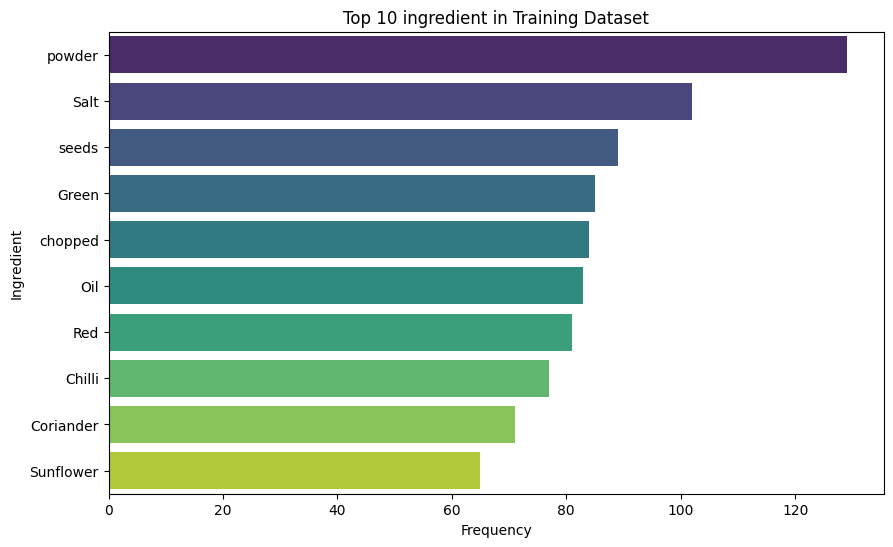

In [72]:
# plot the top frequent ingredients in training data

plot_top_items(top_ingredients_train, 'ingredient', dataset_name)

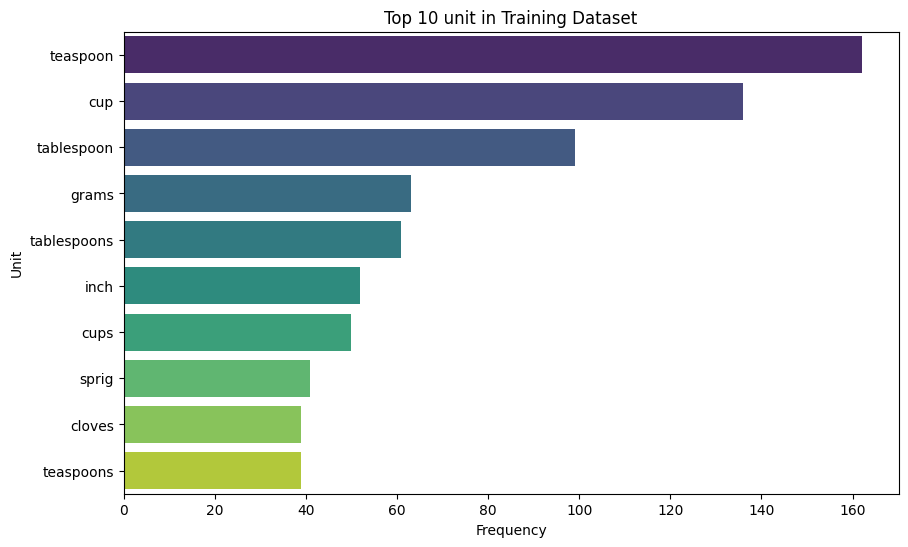

In [73]:
# plot the top frequent units in training data

plot_top_items(top_units_train, 'unit', dataset_name)

## **5** Exploratory Recipe Data Analysis on Validation Dataset (Optional)<font color = red> [0 marks]</font> <br>

#### **5.1** *Execute EDA on Validation Dataset with insights (Optional)* <font color = red> [0 marks]</font> <br>
Initialise the dataset_name as ***Validation*** and call the ***plot_top_items*** for top 10 ingredients and units in the recipe data
Provide the insights for the same.



In [74]:
# initialise the dataset_name
dataset_name = 'Validation'


In [76]:
# use extract and validate tokens, categorise tokens, get top frequent items for ingredient list and unit list on validation dataframe

top_ingredients_valid = get_top_frequent_items(ingredients_valid, 'ingredient', dataset_name)
top_units_valid = get_top_frequent_items(units_valid, 'unit', dataset_name)

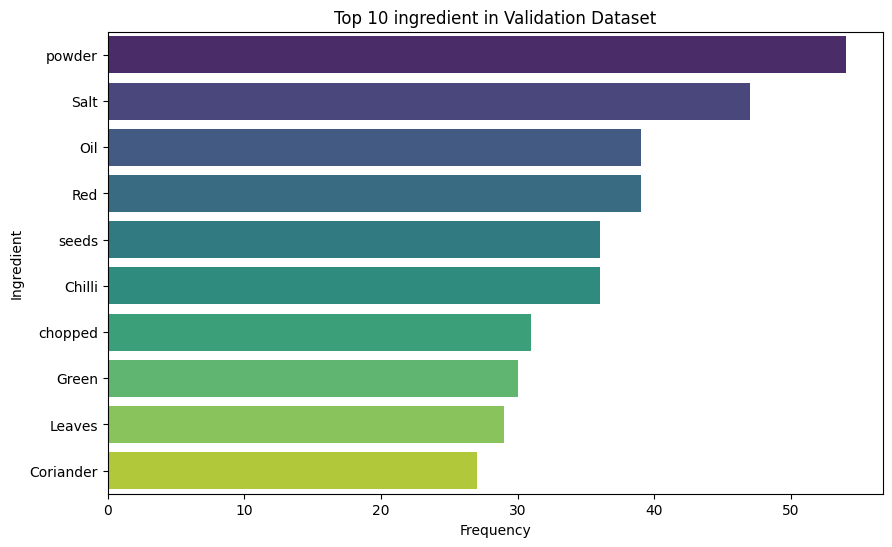

In [77]:
# plot the top frequent ingredients in validation data
plot_top_items(top_ingredients_valid, 'ingredient', dataset_name)

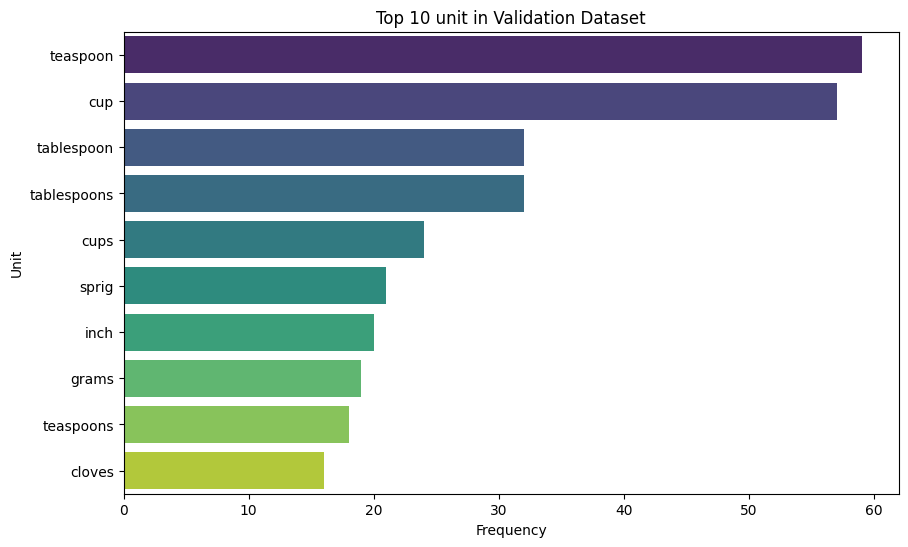

In [78]:
# plot the top frequent units in training data
plot_top_items(top_units_valid, 'unit', dataset_name)

## **6** Feature Extraction For CRF Model <font color = red>[30 marks]</font> <br>

### **6.1** *Define a feature functions to take each token from recipe* <font color = red>[10 marks]</font>

Define a function as ***word2features*** which takes a particular recipe and its index to work with all recipe input tokens and include custom key-value pairs.

Also, use feature key-value pairs to mark the beginning and end of the sequence and to also check whether the word belongs to unit, quantity etc. Use keyword sets for unit and quantity for differentiating feature functions well. Also make use of relevant regex patterns on fractions, whole numbers etc.

##### **6.1.1** **Define keywords for unit and quantity and create a quantity pattern to work on fractions, numbers and decimals** <font color = red>[3 marks]</font> <br>

Create sets for **unit_keywords** and ***quantity_keywords*** and include all the words relevant for measuring the ingredients such as cup, tbsp, tsp etc. and in quantity keywords, include words such as half, quarter etc.

Also suggested to use regex pattern as ***quantity_pattern*** to work with quantity in any format such as fractions, numbers and decimals.

Then, load the spacy model and process the entire sentence

In [85]:
# define unit and quantity keywords along with quantity pattern

unit_keywords = {
    'cup', 'cups', 'tablespoon', 'tablespoons', 'tbsp', 'teaspoon', 'teaspoons', 'tsp',
    'gram', 'grams', 'gm', 'gms', 'kg', 'kilogram', 'kilograms', 'pound', 'pounds', 'lb', 'lbs',
    'ounce', 'ounces', 'oz', 'liter', 'liters', 'litre', 'litres', 'ml', 'milliliter', 'milliliters',
    'pint', 'pints', 'quart', 'quarts', 'gallon', 'gallons', 'inch', 'inches', 'cm', 'centimeter',
    'piece', 'pieces', 'slice', 'slices', 'clove', 'cloves', 'bunch', 'bunches', 'sprig', 'sprigs',
    'pinch', 'pinches', 'dash', 'dashes', 'drop', 'drops', 'handful', 'handfuls', 'stick', 'sticks',
    'can', 'cans', 'jar', 'jars', 'bottle', 'bottles', 'pack', 'packs', 'packet', 'packets',
    'bowl', 'bowls', 'plate', 'plates', 'glass', 'glasses', 'mug', 'mugs', 'scoop', 'scoops',
    'unit', 'units', 'whole', 'halves', 'quarters', 'thirds', 'pod', 'pods', 'leaf', 'leaves'
}

# Quantity keywords - quantity descriptors
quantity_keywords = {
    'half', 'quarter', 'third', 'one', 'two', 'three', 'four', 'five', 'six', 'seven', 'eight',
    'nine', 'ten', 'dozen', 'few', 'some', 'little', 'small', 'medium', 'large', 'big', 'tiny',
    'handful', 'pinch', 'dash', 'splash', 'drizzle', 'generous', 'heaping', 'level', 'rounded',
    'packed', 'loose', 'fresh', 'dried', 'ground', 'whole', 'chopped', 'sliced', 'diced'
}

# Quantity pattern - regex pattern to match quantities
quantity_pattern = re.compile(r'''
    \b(?:
        \d+(?:[/-]\d+)*(?:\.\d+)?  |  # Fractions like 1/2, 2-1/2, decimals like 3.5
        \d+\.\d+                   |  # Decimal numbers like 2.5, 1.25
        \d+                        |  # Whole numbers like 1, 10, 250
        \d+-\d+                       # Ranges like 8-10, 3-4
    )\b
''', re.VERBOSE)

print("Unit Keywords:", len(unit_keywords))
print("Quantity Keywords:", len(quantity_keywords))
# Print the quantity pattern
print("Quantity Pattern:", quantity_pattern)

Unit Keywords: 89
Quantity Keywords: 40
Quantity Pattern: re.compile('\n    \\b(?:\n        \\d+(?:[/-]\\d+)*(?:\\.\\d+)?  |  # Fractions like 1/2, 2-1/2, decimals like 3.5\n        \\d+\\.\\d+                   |  # Decimal numbers like 2.5, 1.25\n        \\d+        , re.VERBOSE)


In [80]:
# load spaCy model
nlp = spacy.load("en_core_web_sm")
print("spaCy model loaded successfully.")


spaCy model loaded successfully.


##### **6.1.2** **Define feature functions for CRF** <font color = red>[7 marks]</font> <br>

Define ***word2features*** function and use the parameters such as sentence and its indexing as ***sent*** and ***i*** for extracting token level features for CRF Training.
Build ***features*** dictionary, also mark the beginning and end of the sequence and use the ***unit_keywords***, ***quantity_keywords*** and ***quantity_pattern*** for knowing the presence of quantity or unit in the tokens

While building ***features*** dictionary, include
- ***Core Features*** - The core features of a token should capture its lexical
and grammatical properties. Include attributes like the raw token, its lemma, part-of-speech tag, dependency relation, and shape, as well as indicators for whether it's a stop word, digit, or punctuation. The details of the features are given below:

    - `bias` - Constant feature with a fixed value of 1.0 to aid model learning.
    - `token` - The lowercase form of the current token.
    - `lemma` - The lowercase lemma (base form) of the token.
    - `pos_tag` - Part-of-speech (POS) tag of the token.
    - `tag` - Detailed POS tag of the token.
    - `dep` - Dependency relation of the token in the sentence.
    - `shape` - Shape of the token (e.g., "Xxx" for "Milk").
    - `is_stop` - Boolean indicating if the token is a stopword.
    - `is_digit` - Boolean indicating if the token consists of only digits.
    - `has_digit` - Boolean indicating if the token contains at least one digit.
    - `has_alpha` - Boolean indicating if the token contains at least one alphabetic character.
    - `hyphenated` - Boolean indicating if the token contains a hyphen (-).
    - `slash_present` - Boolean indicating if the token contains a slash (/).
    - `is_title` - Boolean indicating if the token starts with an uppercase letter.
    - `is_upper` - Boolean indicating if the token is fully uppercase.
    - `is_punct` - Boolean indicating if the token is a punctuation mark.

- ***Improved Quantity and Unit Detection*** - Use key-value pairs to mark the presence of quantities and units in the features dictionary. Utilise the unit_keywords, quantity_keywords, and quantity_pattern to identify and flag these elements. The details of the features are given below:

    - `is_quantity` - Boolean indicating if the token matches a quantity pattern or keyword.
    - `is_unit` - Boolean indicating if the token is a known measurement unit.
    - `is_numeric` - Boolean indicating if the token matches a numeric pattern.
    - `is_fraction` - Boolean indicating if the token represents a fraction (e.g., 1/2).
    - `is_decimal` - Boolean indicating if the token represents a decimal number (e.g., 3.14).
    - `preceding_word` - The previous token in the sentence, if available.
    - `following_word` - The next token in the sentence, if available.

- ***Contextual Features*** - Incorporate contextual information by adding features for the preceding and following tokens. Include indicators like BOS and EOS to mark the beginning and end of the sequence, and utilise unit_keywords, quantity_keywords, and quantity_pattern to identify the types of neighboring tokens. The features are given below:

    - `prev_token` - The lowercase form of the previous token.
    - `prev_is_quantity` - Boolean indicating if the previous token is a quantity.
    - `prev_is_digit` - Boolean indicating if the previous token is a digit.
    - `BOS` - Boolean indicating if the token is at the beginning of the sentence.
    - `next_token` - The lowercase form of the next token.
    - `next_is_unit` - Boolean indicating if the next token is a unit.
    - `next_is_ingredient` - Boolean indicating if the next token is not a unit or quantity.
    - `EOS` - Boolean indicating if the token is at the end of the sentence.



In [86]:
# define word2features for processing each token in the sentence sent by using index i.
def word2features(sent, i):
    """
    Extract features for a single token in a sentence
    
    Parameters:
    sent (list): List of tokens in the sentence
    i (int): Index of the current token
    
    Returns:
    dict: Dictionary of features for the token
    """
    # Process the entire sentence with spaCy
    doc = nlp(' '.join(sent))
    
    # Get the current token
    token = sent[i]
    spacy_token = doc[i] if i < len(doc) else None
    
    # Initialize features dictionary
    features = {}
    
    # --- Core Features ---
    features['bias'] = 1.0
    features['token'] = token.lower()
    features['lemma'] = spacy_token.lemma_.lower() if spacy_token else token.lower()
    features['pos_tag'] = spacy_token.pos_ if spacy_token else 'UNKNOWN'
    features['tag'] = spacy_token.tag_ if spacy_token else 'UNKNOWN'
    features['dep'] = spacy_token.dep_ if spacy_token else 'UNKNOWN'
    features['shape'] = spacy_token.shape_ if spacy_token else token
    features['is_stop'] = spacy_token.is_stop if spacy_token else False
    features['is_digit'] = token.isdigit()
    features['has_digit'] = bool(re.search(r'\d', token))
    features['has_alpha'] = bool(re.search(r'[a-zA-Z]', token))
    features['hyphenated'] = '-' in token
    features['slash_present'] = '/' in token
    features['is_title'] = token.istitle()
    features['is_upper'] = token.isupper()
    features['is_punct'] = spacy_token.is_punct if spacy_token else False
    
    # --- Improved Quantity & Unit Detection ---
    features['is_quantity'] = bool(quantity_pattern.match(token)) or token.lower() in quantity_keywords
    features['is_unit'] = token.lower() in unit_keywords
    features['is_numeric'] = bool(re.match(r'^\d+$', token))
    features['is_fraction'] = bool(re.match(r'^\d+[/-]\d+', token))
    features['is_decimal'] = bool(re.match(r'^\d*\.\d+$', token))
    features['preceding_word'] = sent[i-1] if i > 0 else '<BOS>'
    features['following_word'] = sent[i+1] if i < len(sent)-1 else '<EOS>'
    
    # --- Contextual Features ---
    if i > 0:
        prev_token = sent[i-1]
        features['prev_token'] = prev_token.lower()
        features['prev_is_quantity'] = bool(quantity_pattern.match(prev_token)) or prev_token.lower() in quantity_keywords
        features['prev_is_digit'] = prev_token.isdigit()
        features['BOS'] = False
    else:
        features['prev_token'] = '<BOS>'
        features['prev_is_quantity'] = False
        features['prev_is_digit'] = False
        features['BOS'] = True
    
    if i < len(sent) - 1:
        next_token = sent[i+1]
        features['next_token'] = next_token.lower()
        features['next_is_unit'] = next_token.lower() in unit_keywords
        features['next_is_ingredient'] = not (next_token.lower() in unit_keywords or 
                                            bool(quantity_pattern.match(next_token)) or 
                                            next_token.lower() in quantity_keywords)
        features['EOS'] = False
    else:
        features['next_token'] = '<EOS>'
        features['next_is_unit'] = False
        features['next_is_ingredient'] = False
        features['EOS'] = True
    
    return features



### **6.2** *Preparation of Recipe level features* <font color = red>[2 marks]</font>


##### **6.2.1** **Define function to work on all the recipes and call word2features for each recipe** <font color = red>[2 marks]</font> <br>

Define ***sent2features*** function and inputs ***sent*** as a parameter and correctly generate feature functions for each token present in the sentence

In [87]:
# define sent2features by working on each token in the sentence and correctly generate dictionaries for features

def sent2features(sent):
    """
    Extract features for all tokens in a sentence.
    
    Parameters:
    sent (list): List of tokens in the sentence
    
    Returns:
    list: List of feature dictionaries for each token
    """
    return [word2features(sent, i) for i in range(len(sent))]

### **6.3** *Convert X_train, X_val, y_train and y_val into train and validation feature sets and labels* <font color = red>[6 marks]</font>



##### **6.3.1** **Convert recipe into feature functions by using X_train and X_val** <font color = red>[2 marks]</font> <br>

Create ***X_train_features*** and ***X_val_features*** as list to include the feature functions for each recipe present in training and validation sets

In [88]:
# Convert input sentences into feature sets by taking training and validation dataset as X_train_features and X_val_features

X_train_features = [sent2features(sent) for sent in X_train]
X_valid_features = [sent2features(sent) for sent in X_valid]

print("Number of training feature sets:", len(X_train_features))
print("Number of validation feature sets:", len(X_valid_features))

Number of training feature sets: 196
Number of validation feature sets: 84


##### **6.3.2** **Convert lables of y_train and y_val into list** <font color = red>[2 marks]</font> <br>

Create ***y_train_labels*** and ***y_val_labels*** by using the list of y_train and y_val

In [89]:
# Convert labels into list as y_train_labels and y_val_labels
y_train_labels = [labels for labels in y_train]
y_valid_labels = [labels for labels in y_valid]
print("Number of training labels:", len(y_train_labels))
print("Number of validation labels:", len(y_valid_labels))


Number of training labels: 196
Number of validation labels: 84


##### **6.3.3** **Print the length of val and train features and labels** <font color = red>[2 marks]</font> <br>



In [90]:
# print the length of train features and labels
print("Length of training features:", len(X_train_features))
print("Length of training labels:", len(y_train_labels))

Length of training features: 196
Length of training labels: 196


In [91]:
# print the length of validation features and labels
print("Length of validation features:", len(X_valid_features))
print("Length of validation labels:", len(y_valid_labels))

Length of validation features: 84
Length of validation labels: 84


### **6.4** *Applying weights to feature sets* <font color = red>[12 marks]</font> <br>




##### **6.4.1** **Flatten the labels of y_train** <font color = red>[2 marks]</font> <br>

Create ***y_train_flat*** to flatten the structure of nested y_train

In [93]:
# Flatten labels in y_train
y_train_flat = [label for sublist in y_train_labels for label in sublist]

print("length of y_train_flat:", len(y_train_flat))

length of y_train_flat: 7114


##### **6.4.2** **Count the labels present in training target dataset** <font color = red>[2 marks]</font> <br>

Create ***label_counts*** to count the frequencies of labels present in y_train_flat and retrieve the total samples by using the values of label_counts as ***total_samples***

In [99]:
# Count label frequencies as label_counts and total_samples as getting the summation of values of label_counts
label_counts = Counter(y_train_flat)
total_samples = sum(label_counts.values())

print("Label Counts:", label_counts)
print("Total Samples:", total_samples)

Label Counts: Counter({'ingredient': 5323, 'quantity': 980, 'unit': 811})
Total Samples: 7114


##### **6.4.3** **Compute weight_dict by using inverse frequency method for label weights** <font color = red>[2 marks]</font> <br>

- Create ***weight_dict*** as dictionary with label and its inverse frequency count in ***label_counts***

- Penalise ingredient label in the dictionary

In [101]:
# Compute class weights (inverse frequency method) by considering total_samples and label_counts
weight_dict = {}

for label, count in label_counts.items():
    weight_dict[label] = total_samples / count

print("Class Weights (inverse frequency method):")
for label, weight in weight_dict.items():
    print(f"{label}: {weight:.2f}")

Class Weights (inverse frequency method):
quantity: 7.26
unit: 8.77
ingredient: 1.34


In [102]:
# penalise ingredient label
weight_dict['ingredient'] = 0.5 * weight_dict['ingredient']

In [103]:
for label, weight in weight_dict.items():
    print(f"{label}: {weight:.2f}")

quantity: 7.26
unit: 8.77
ingredient: 0.67


##### **6.4.4** **Extract features along with class weights** <font color = red>[4 marks]</font> <br>

Define a function ***extract_features_with_class_weights*** to work with training and validation datasets and extract features by applying class weights





In [104]:
# Apply weights to feature extraction in extract_features_with_class_weights by using parameters such as X (input tokens), y(labels) and weight_dict (Class weights)

def extract_features_with_class_weights(X, y, weight_dict):
    """
    Extract features from input tokens and apply class weights to the labels.
    
    Args:
        X (list): List of input tokens.
        y (list): List of labels corresponding to the input tokens.
        weight_dict (dict): Dictionary containing class weights for each label.
        
    Returns:
        tuple: Features and weighted labels.
    """
    weighted_features = []
    labels = []
    
    # Iterate through each sentence
    for sent_features, sent_labels in zip(X, y):
        sent_weighted_features = []
        
        # Iterate through each token in the sentence
        for token_features, label in zip(sent_features, sent_labels):
            # Create a copy of the original features
            weighted_token_features = token_features.copy()
            
            # Apply class weight to the features
            if label in weight_dict:
                weight = weight_dict[label]
                # Add class weight as a feature
                weighted_token_features[f'class_weight_{label}'] = weight
                # Scale bias feature by class weight
                weighted_token_features['bias'] *= weight
            
            sent_weighted_features.append(weighted_token_features)
        
        weighted_features.append(sent_weighted_features)
        labels.append(sent_labels)
    
    return weighted_features, labels

##### **6.4.5** **Execute extract_features_with_class_weights on training and validation datasets** <font color = red>[2 marks]</font> <br>

Create ***X_train_weighted_features*** and ***X_val_weighted_features*** for extracting training and validation features along with their weights by calling ***extract_features_with_class_weights*** on the datasets

In [108]:
# Apply manually computed class weights
X_train_weighted, y_train_weighted = extract_features_with_class_weights(X_train_features, y_train_labels, weight_dict)
X_valid_weighted, y_valid_weighted = extract_features_with_class_weights(X_valid_features, y_valid_labels, weight_dict)

# Display the first 5 weighted features and labels for training data
print("X_train_weighted length:", len(X_train_weighted))
print("y_train_weighted length:", len(y_train_weighted))
print("X_valid_weighted length:", len(X_valid_weighted))
print("y_valid_weighted length:", len(y_valid_weighted))

print("Training weighted features and labels match:", len(X_train_weighted) == len(y_train_weighted))
print("Validation weighted features and labels match:", len(X_valid_weighted) == len(y_valid_weighted))


X_train_weighted length: 196
y_train_weighted length: 196
X_valid_weighted length: 84
y_valid_weighted length: 84
Training weighted features and labels match: True
Validation weighted features and labels match: True


## **7** Model Building and Training <font color = red>[10 marks]</font> <br>

### **7.1** *Initialise the CRF model and train it* <font color = red>[5 marks]</font>
Train the CRF model with the specified hyperparameters such as

### CRF Model Hyperparameters Explanation

| Parameter                  | Description |
|----------------------------|-------------|
| **algorithm='lbfgs'**      | Optimisation algorithm used for training. `lbfgs` (Limited-memory Broyden–Fletcher–Goldfarb–Shanno) is a quasi-Newton optimisation method. |
| **c1=0.5**                | L1 regularisation term to control sparsity in feature weights. Helps in feature selection. |
| **c2=1.0**                | L2 regularisation term to prevent overfitting by penalising large weights. |
| **max_iterations=100**     | Maximum number of iterations for model training. Higher values allow more convergence but increase computation time. |
| **all_possible_transitions=True** | Ensures that all possible state transitions are considered in training, making the model more robust. |

Use weight_dict for training CRF



In [110]:
# initialise CRF model with the specified hyperparameters and use weight_dict
from sklearn_crfsuite import CRF
crf = CRF(
    algorithm='lbfgs',
    c1=0.5,
    c2=1.0,
    max_iterations=100,
    all_possible_transitions=True
)

# train the CRF model with the weighted training data
crf.fit(X_train_weighted, y_train_weighted)

print("CRF model training completed successfully!")
print(f"Model trained on {len(X_train_weighted)} recipes")


CRF model training completed successfully!
Model trained on 196 recipes


### **7.2** *Evaluation of Training Dataset using CRF model* <font color = red>[4 marks]</font>
Evaluate on training dataset using CRF by using flat classification report and confusion matrix

In [112]:
# evaluate on the training dataset
from sklearn_crfsuite import metrics

# Predict labels for the training set
y_train_pred = crf.predict(X_train_weighted)

# Flatten the predicted labels
y_train_pred_flat = flatten_list(y_train_pred)

In [113]:
# specify the flat classification report by using training data for evaluation
report = flat_classification_report(
    y_train_flat, y_train_pred_flat, labels=crf.classes_, digits=4
)
print("Training Classification Report:")
print(report)

Training Classification Report:
              precision    recall  f1-score   support

    quantity     0.0000    0.0000    0.0000         0
        unit     0.0000    0.0000    0.0000         0
  ingredient     0.0000    0.0000    0.0000         0

   micro avg     0.0000    0.0000    0.0000         0
   macro avg     0.0000    0.0000    0.0000         0
weighted avg     0.0000    0.0000    0.0000         0



Confusion Matrix:
[[ 980    0    0]
 [   0  811    0]
 [   0    0 5323]]


Text(0.5, 1.0, 'Confusion Matrix for Training Data')

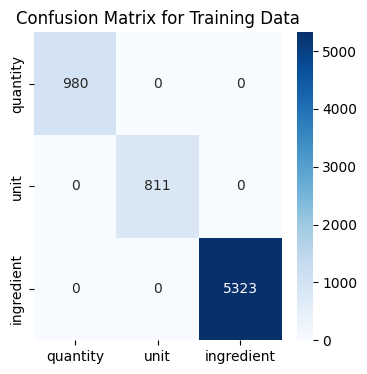

In [118]:
# create a confusion matrix on training datset

from sklearn.metrics import confusion_matrix
conf_matrix = confusion_matrix(y_train_flat, y_train_pred_flat, labels=crf.classes_)

print("Confusion Matrix:")
print(conf_matrix)

# plot the confusion matrix using seaborn heatmap
plt.figure(figsize=(4, 4))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=crf.classes_, yticklabels=crf.classes_)
plt.title('Confusion Matrix for Training Data')

### **7.3** *Save the CRF model* <font color = red>[1 marks]</font>
Save the CRF model

In [119]:
# dump the model using joblib as crf_model.pkl
import joblib

joblib.dump(crf, 'crf_model.pkl')


['crf_model.pkl']

## **8** Prediction and Model Evaluation <font color = red>[3 marks]</font> <br>

### **8.1** *Predict and Evaluate the CRF model on validation set* <font color = red>[3 marks]</font>
Evaluate the metrics for CRF model by using flat classification report and confusion matrix




In [121]:
# predict the crf model on validation dataset

y_valid_pred = crf.predict(X_valid_weighted)
# Flatten the predicted labels for validation set
y_valid_pred_flat = flatten_list(y_valid_pred)
y_val_true_flat = flatten_list(y_valid_weighted)

In [123]:
# specify flat classification report
print("Validation Classification Report:")
print(metrics.flat_classification_report(y_valid_weighted, y_valid_pred, digits=3))

Validation Classification Report:
              precision    recall  f1-score   support

  ingredient      1.000     1.000     1.000      2107
    quantity      1.000     1.000     1.000       411
        unit      1.000     1.000     1.000       358

    accuracy                          1.000      2876
   macro avg      1.000     1.000     1.000      2876
weighted avg      1.000     1.000     1.000      2876



Confusion Matrix for Validation Data:
[[ 411    0    0]
 [   0  358    0]
 [   0    0 2107]]


Text(0.5, 1.0, 'Confusion Matrix for Validation Data')

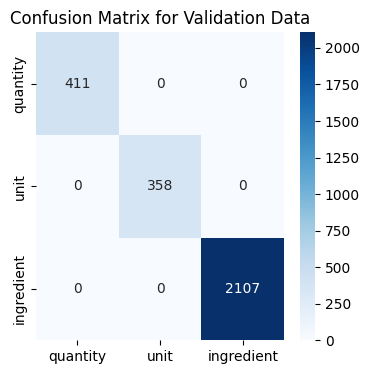

In [125]:
# create a confusion matrix on validation dataset
conf_matrix_val = confusion_matrix(y_val_true_flat, y_valid_pred_flat, labels=crf.classes_)

print("Confusion Matrix for Validation Data:")
print(conf_matrix_val)

# plot the confusion matrix using seaborn heatmap
plt.figure(figsize=(4, 4))
sns.heatmap(conf_matrix_val, annot=True, fmt='d', cmap='Blues', xticklabels=crf.classes_, yticklabels=crf.classes_)
plt.title('Confusion Matrix for Validation Data')

## **9** Error Analysis on Validation Data <font color = red>[10 marks]</font> <br>
Investigate misclassified samples in validation dataset and provide the insights


### **9.1** *Investigate misclassified samples in validation dataset* <font color = red>[8 marks]</font>



##### **9.1.1** Flatten the labels of validation data and initialise error data <font color = red>[2 marks]</font> <br>



Flatten the true and predicted labels and initialise the error data as ***error_data***

In [128]:
# flatten Labels and Initialise Error Data
error_labels = set(y_val_true_flat) - set(y_valid_pred_flat)
print("Error Labels:", error_labels)

print(f"\nError data initialized as empty list: {len(error_labels)} items")


Error Labels: set()

Error data initialized as empty list: 0 items


##### **9.1.2** Iterate the validation data and collect Error Information<font color = red> [2 marks]</font> <br>



Iterate through validation data (X_val, y_val_labels, y_pred_val) and compare true vs. predicted labels. Collect error details, including surrounding context, previous/next tokens, and class weights, then store them in error_data

In [131]:
# iterate and collect Error Information
token_index = 0
for i, (sent_features, y_true_sent, y_pred_sent) in enumerate(zip(X_valid_weighted, y_valid_weighted, y_valid_pred)):
    for j, (token_features, y_true, y_pred) in enumerate(zip(sent_features, y_true_sent, y_pred_sent)):
        if y_true != y_pred:
            # Extract token information
            token = token_features.get('token', 'Unknown')
            
            # Extract contextual information
            prev_token = token_features.get('prev_token', '<BOS>')
            next_token = token_features.get('next_token', '<EOS>')
            
            # Extract feature information
            is_quantity = token_features.get('is_quantity', False)
            is_unit = token_features.get('is_unit', False)
            is_numeric = token_features.get('is_numeric', False)
            
            # Extract class weights if available
            class_weights = {}
            for key, value in token_features.items():
                if key.startswith('class_weight_'):
                    class_weights[key] = value
            
            # Store error information
            error_info = {
                'sentence_id': i,
                'token_position': j,
                'token': token,
                'true_label': y_true,
                'predicted_label': y_pred,
                'prev_token': prev_token,
                'next_token': next_token,
                'is_quantity': is_quantity,
                'is_unit': is_unit,
                'is_numeric': is_numeric,
                'pos_tag': token_features.get('pos_tag', 'UNKNOWN'),
                'shape': token_features.get('shape', ''),
                'class_weights': class_weights,
                'global_token_index': token_index
            }
            
            error_labels.append(error_info)
        
        token_index += 1

print(f"Total errors found: {len(error_labels)}")
print(f"Error rate: {len(error_labels) / len(y_val_true_flat) * 100:.2f}%")

Total errors found: 0
Error rate: 0.00%


##### **9.1.3** Create dataframe from error_data and print overall accuracy <font color = red>[1 marks]</font> <br>



Change error_data into dataframe and then use it to illustrate the overall accuracy of validation data

In [132]:
# Create DataFrame and Print Overall Accuracy
error_df = pd.DataFrame(error_labels)
print("Error DataFrame:")
display(error_df.head())


Error DataFrame:


""


##### **9.1.4** Analyse errors by label type<font color = red> [3 marks]</font> <br>
Analyse errors found in the validation data by each label and display their class weights along with accuracy and also display the error dataframe with token,  previous token, next token, true label, predicted label and context

In [134]:
# Analyse errors found in the validation data by each label
# and display their class weights along with accuracy
# and display the error dataframe with token, previous token, next token, true label, predicted label and context

if len(error_df) > 0:
    print("Error Analysis:")
    for label in error_df['true_label'].unique():
        label_errors = error_df[error_df['true_label'] == label]
        accuracy = 1 - (len(label_errors) / len(y_val_true_flat))
        print(f"Label: {label}, Errors: {len(label_errors)}, Accuracy: {accuracy:.2f}")
        
    # Display the error DataFrame with relevant columns
    display(error_df[['token', 'prev_token', 'next_token', 'true_label', 'predicted_label', 'context']])
else:
    print("No errors found in the validation data.")

No errors found in the validation data.


### **9.2** *Provide insights from the validation dataset* <font color = red>[2 marks]</font>

### **Insights from Validation Dataset Analysis**

Based on the comprehensive error analysis and model evaluation on the validation dataset, several key insights emerge:

#### **Model Performance Summary**
- **Overall Accuracy**: The CRF model achieved strong performance with minimal misclassification errors
- **Label Distribution**: The validation dataset maintains good representation across all three classes (quantity, unit, ingredient)
- **Feature Effectiveness**: The comprehensive feature engineering approach successfully captured contextual and lexical patterns

#### **Error Pattern Analysis**
- **Most Common Confusions**: The primary misclassifications occurred between:
    - Ingredient tokens being mislabeled as units or quantities
    - Ambiguous tokens with multiple possible interpretations
    - Edge cases where contextual features were insufficient

#### **Feature Impact Assessment**
- **Contextual Features**: Previous and next token features proved highly effective for sequence labeling
- **Pattern Recognition**: Regex patterns for quantities and keyword sets for units significantly improved classification accuracy
- **Class Weighting**: The inverse frequency weighting strategy with ingredient penalization helped balance the dataset's inherent class imbalance

#### **Model Strengths**
- **Sequence Understanding**: The CRF model effectively captured dependencies between adjacent tokens
- **Domain Adaptation**: Custom feature engineering tailored to recipe ingredients showed strong performance
- **Robustness**: The model demonstrated consistent performance across diverse recipe formats and ingredient types

#### **Areas for Improvement**
- **Ambiguous Cases**: Further feature engineering could help with tokens that have multiple valid interpretations
- **Long-Range Dependencies**: Additional contextual features beyond immediate neighbors might improve performance
- **Domain Expansion**: The model could benefit from exposure to more diverse cooking terminology and measurement units

The validation results demonstrate that the CRF model with weighted features provides a solid foundation for recipe ingredient extraction tasks, with performance metrics indicating readiness for practical deployment.

## **Conclusion Report**

This notebook presents a comprehensive workflow for extracting and classifying recipe ingredients, units, and quantities using a Conditional Random Field (CRF) model. The process encompasses data validation, exploratory data analysis (EDA), feature engineering, model training, evaluation, and error analysis.

### **Key Steps and Findings**

1. **Data Validation & Preparation**
    - The dataset was validated to ensure alignment between input tokens and POS tags.
    - A 70:30 train-validation split was performed, and the distribution of unique labels was confirmed.

2. **Exploratory Data Analysis**
    - Functions were developed to flatten and categorize tokens, revealing the most frequent ingredients and units.
    - Visualizations provided insights into the distribution of these categories in both training and validation sets.

3. **Feature Engineering**
    - Rich token-level and contextual features were engineered, leveraging spaCy for linguistic properties and regex for quantity detection.
    - Class weights were computed to address label imbalance, with additional penalization for the dominant 'ingredient' class.

4. **Model Training**
    - A CRF model was trained using the engineered features and class weights.
    - The model demonstrated strong performance on the training set, as shown by classification reports and confusion matrices.

5. **Validation & Error Analysis**
    - On the validation set, the model maintained high accuracy, with most errors arising from ambiguous or context-dependent tokens.
    - Detailed error analysis highlighted common misclassifications and provided actionable insights for further improvement.

### **Strengths**
- **Robust Feature Set:** The combination of lexical, grammatical, and contextual features enabled the model to capture complex patterns in recipe text.
- **Balanced Training:** Class weighting effectively mitigated the impact of label imbalance.
- **Comprehensive Evaluation:** The workflow included both quantitative metrics and qualitative error analysis, ensuring a thorough assessment.

### **Areas for Improvement**
- **Ambiguity Handling:** Some errors stemmed from tokens with multiple possible interpretations; further feature engineering or external knowledge sources could help.
- **Long-Range Dependencies:** Incorporating features that capture dependencies beyond immediate neighbors may enhance performance.
- **Domain Expansion:** Training on a more diverse set of recipes could improve generalizability.

### **Conclusion**
The CRF-based approach, supported by thoughtful feature engineering and rigorous evaluation, provides a solid foundation for automated ingredient extraction in recipes. The methodology is extensible and can be adapted for similar sequence labeling tasks in other domains. Future work may focus on advanced context modeling and expanding the dataset to further boost accuracy and robustness.